In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Kalman datasets

/content/drive/MyDrive/Kalman datasets


In [3]:
# ===== Imports & Setup =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_squared_error

# Chỉ load 3 cột cần thiết để tiết kiệm bộ nhớ
train = pd.read_csv('/content/drive/MyDrive/Kalman datasets/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/Kalman datasets/test.csv')

In [4]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

df = pd.read_csv('/content/drive/MyDrive/Kalman datasets/train.csv')
print("All columns:", df.columns.tolist())

# Publication_Day == 'Wednesday'
df_wed = df[df['Publication_Day'] == 'Wednesday'].reset_index(drop=True)
print(f"Rows with Wednesday: {len(df_wed)}\n")

All columns: ['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Listening_Time_minutes']
Rows with Wednesday: 107886



In [11]:
# Split train set into 80% train and 20% validation
cut = int(len(df_wed) * 0.8)
train_set = df_wed.iloc[:cut].reset_index(drop=True)
val_set = df_wed.iloc[cut:].reset_index(drop=True)

In [19]:
y = df_wed['Listening_Time_minutes']

X = df_wed.drop(columns=['id', 'Listening_Time_minutes'])

print("shape:", X.shape)

shape: (107886, 10)


In [18]:
models = {
    'Model1_LL': UnobservedComponents(endog=y, level=True, trend=False, seasonal=None),
    'Model2_LLT': UnobservedComponents(endog=y, level=True, trend=True,  seasonal=None),
    'Model3_LLTS7': UnobservedComponents(endog=y, level=True, trend=True,  seasonal=7),
}

results = {}
for name, mod in models.items():
    print(f"Fitting {name} ...")
    res = mod.fit(disp=False)
    results[name] = res
    print(f"  AIC: {res.aic:.1f}, BIC: {res.bic:.1f}\n")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Fitting Model1_LL ...
  AIC: 1017686.9, BIC: 1017696.5

Fitting Model2_LLT ...
  AIC: 1017710.8, BIC: 1017720.3

Fitting Model3_LLTS7 ...
  AIC: 1229263.6, BIC: 1229273.2



Best model based on AIC: Model1_LL



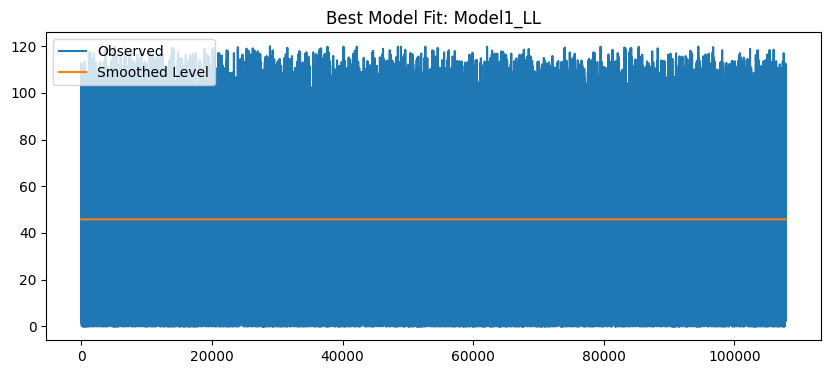

In [16]:
# ===== Plot Smoothed Level for Best Model =====
# Determine best by AIC
best_name = min(results, key=lambda n: results[n].aic)
best_res = results[best_name]
print(f"Best model based on AIC: {best_name}\n")

plt.figure(figsize=(10, 4))
plt.plot(y.index, y, label='Observed')
plt.plot(y.index, best_res.smoothed_state[0], label='Smoothed Level')
plt.title(f'Best Model Fit: {best_name}')
plt.legend()
plt.show()

In [17]:
# ===== RMSE for all models and choose the best one =====
from sklearn.metrics import mean_squared_error

# Lọc validation chỉ cho ngày 'Wednesday'
val_wed = val_set[val_set['Publication_Day'] == 'Wednesday'].reset_index(drop=True)
y_val = val_wed['Listening_Time_minutes']

rmses = {}

for name, res in results.items():
    pred = res.get_forecast(steps=len(y_val)).predicted_mean
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmses[name] = rmse

df_rmse = pd.DataFrame({
    'Model': list(rmses.keys()),
    'RMSE': list(rmses.values())
})
print(df_rmse.to_string(index=False))

best_model = min(rmses, key=rmses.get)
print(f"\nBest model based on RMSE: {best_model}")

       Model      RMSE
   Model1_LL 27.073345
  Model2_LLT 27.073315
Model3_LLTS7 35.745746

Best model based on RMSE: Model2_LLT


In [20]:
import pandas as pd
test_wed = test[test['Publication_Day'] == 'Wednesday'].reset_index(drop=True)
X_test = test_wed.drop(columns=['id', 'Publication_Day'])

#Best model based on RMSE
best_res = results[best_model]
test_pred = best_res.get_forecast(steps=len(test_wed), exog=X_test).predicted_mean

test_wed['Listening_Time_minutes'] = test_pred.values

prediction_output = test_wed[['id', 'Listening_Time_minutes']]
prediction_output.to_csv('prediction.csv', index=False)

print("Đã lưu kết quả dự báo vào file 'prediction.csv'.")


Đã lưu kết quả dự báo vào file 'prediction.csv'.
